## Tópicos Especiais em Inteligência Artificial

## Classificação de diagnóstico de câncer de mama com Deep Neural Network (DNN)

Neste trabalho vamos utilizar o Dataset Breast Cancer Wisconsin (Diagnostic)
disponível no repositório de datasets da UCI. Este é um conjunto de dados multivariado com atributos numéricos de ponto-flutuante usando para classificação do tipo de câncer de mama de um paciente com MALIGNO ou BANIGNO. O dataset mostra resultados de exames de 699 pacientes coletados entre 1989 e 1991. É composto de 11 atributos que são usados como entrada no modelo:

1.  ID do paciente
2.  Esperssura (1-10)
3.  Uniformidade de tamanho da célula (1-10)
4.  Uniformidade de forma da célula (1-10)
5.  Adesão marginal (1-10)
6.  Tamanho único epitelial da célula (1-10)
7.  Quantidade de núcleos nus (1-10)
8.  Cromatia (1-10)
9.  Quantidade de núcleos normais (1-10)
10. Mitoses (1-10)
11. [SAÍDA] Classificação (2 para indicar BENIGNO, 4 para indicar MALIGNO)

O dataset contém 458 amostras com:
- 65.5% de casos BENIGNOS
- 34.5% de casos MALIGNOS

## 1. Preparação do Ambiente

In [1]:
# Fução para deixar o jupter com células preenchendo a tela toda
# from Ipython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# Importação de pacotes necessários

# Exportando requirisments.txt
import subprocess
import sys


#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load



#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

#bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

c:\Users\gusta\anaconda3\envs\breast\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.2.0 (SDL 2.32.56, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Checagem de GPU 
import tensorflow as tf
import keras
print("tensorflow version:", tf.__version__)
print("keras version:", keras.__version__)

print("GPU disponível:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')) > 0)



tensorflow version: 2.19.1
keras version: 3.11.2
GPU disponível: 2.19.1
Num GPUs Available:  False


In [4]:
# Rotina para exportar os pacotes instalados no ambiente virtual para um arquivo requirements.txt
def export_requirements():
    try:
        resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'],
                                capture_output=True, 
                                text=True,
                                check=True)
        with open('requirements.txt', 'w') as f:
            f.write(resultado.stdout)
        print("Arquivo requirements.txt exportado com sucesso!")
    except subprocess.CalledProcessError as e:
        print("Erro ao exportar requirements.txt:", e)
export_requirements()

Arquivo requirements.txt exportado com sucesso!


# 2. Importação do dataset

In [5]:
col_names = ['ID', 'espessura', 'tam_celula', 'forma_celula', 'adesao', 'tam_epitelial', 'nucleos_nus', 'cromatina',
             'nucleos_normais', 'mitoses', 'diagnostico']

# Importação do dataset
data = pd.read_csv('dataset/breast-cancer-wisconsin.csv', header=None, names=col_names)

# Remoção da coluna ID, pois ela não agrega valor ao modelo
data = data.drop(['ID'], axis=1)

# Substituição de valores ausentes representados por "?" por NaN
data = data.replace('?', np.nan)

# Conversão das colunas para o tipo numérico
data = data.astype(float)

# Converte o código do diagnóstico
data = data.assign(diagnostico=data['diagnostico'].replace({2: 0, 4: 1}))  

# Nomeando as entradas e saídas
x_names = data.columns[:-1].tolist()
y_names = data.columns[-1:].tolist()



In [6]:
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0
695,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,1.0
697,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,1.0


## 3. Configuração do experimento

In [ ]:
# Realizar interpolação de dados 
interp_exec = True

# Realizar deteccao e substituicao de outliers
outilier_exec =  True

# Realizar normalização dos dados
normalization_exec = True

# Realizar escalação dos dados
scale_exec = True

# Exportar os datasets pré-processados
export_frames = False

# Gerar um novo modelo ou carregar um modelo existente
new_model_exec = True

# 4. Análise de Dados

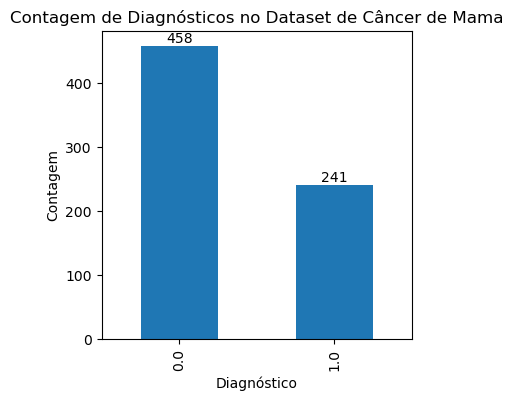

In [8]:
# Contagem de diagnósticos
diag_counts = data['diagnostico'].value_counts()

# Plota gráfico de barras
plt.figure(figsize=(4,4))
diag_counts.plot(kind='bar')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')
plt.title('Contagem de Diagnósticos no Dataset de Câncer de Mama')

# Adiciona rótulos de contagem nas barras
for i, count in enumerate(diag_counts):
    plt.text(i, count, str(count),ha='center', va='bottom')
plt.show()

### 4.1. Sumarização estatística 

In [9]:
def sumarizacao_estatistica(data):
    stats = []

    for column in x_names:
        values = data[column]
        maximum = round(values.max(), 2)
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)

        stats.append([column, maximum, minimum, mean, median, std])
    
    headers = ["Coluna", "Máximo", "Mínimo", "Média", "Mediana", "Desvio Padrão"]

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)
sumarizacao_estatistica(data)


| Coluna          |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| espessura       |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula      |       10 |        1 |    3.13 |         1 |            3.05 |
| forma_celula    |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao          |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial   |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus     |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina       |       10 |        1 |    3.44 |         3 |            2.44 |
| nucleos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses         |       10 |        1 |    1.59 |         1 |            1.72 |


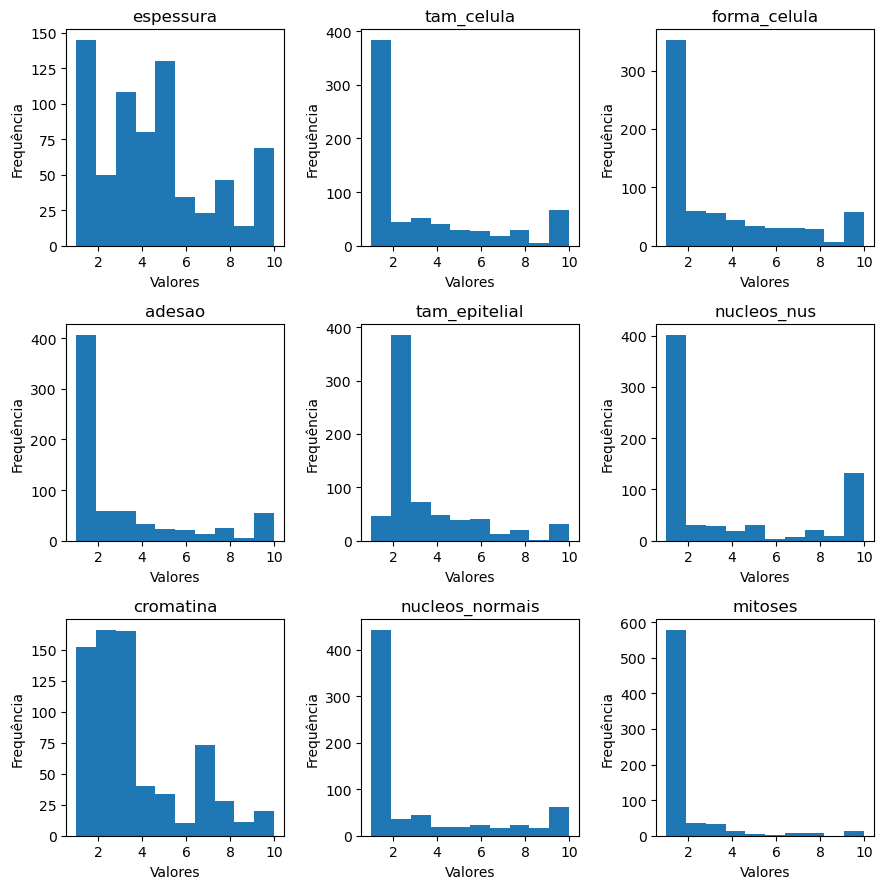

In [10]:
fig, axs = plt.subplots(3,3, figsize=(9,9), tight_layout=True)

for i, column in enumerate(x_names):
    row = i // 3
    col = i % 3
    axs[row, col].hist(data[column], bins=10)
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequência')

plt.show()
    

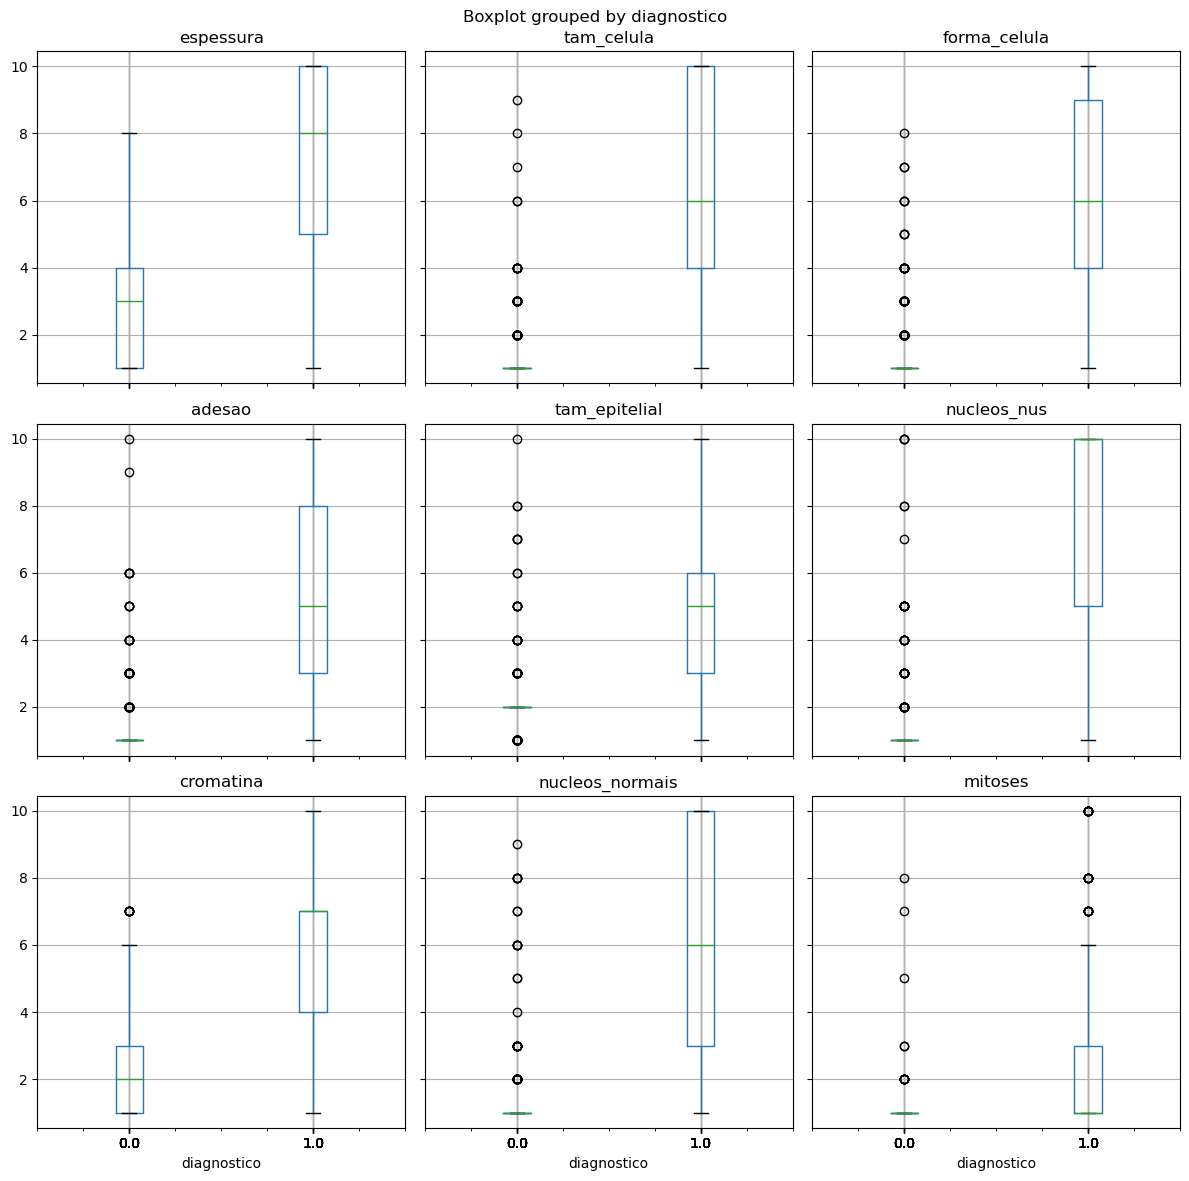

In [11]:
data.boxplot(column=x_names, by='diagnostico', figsize=(12,12))
plt.tight_layout()
plt.show()

### 4.2  Detecção de dados faltantes e interpolação

In [14]:
missin_counts = data.isnull().sum()
print("Total de dados faltantes por atributo:")
print(missin_counts)

Total de dados faltantes por atributo:
espessura           0
tam_celula          0
forma_celula        0
adesao              0
tam_epitelial       0
nucleos_nus        16
cromatina           0
nucleos_normais     0
mitoses             0
diagnostico         0
dtype: int64


In [26]:
def interpolacao(data):
    if data.isnull().values.any():
        points_inds_danger = [0, 1, len(data) - 2, len(data) - 1]
        for colname in x_names:
            for ind_danger in points_inds_danger:
                if np.isnan(data[colname].iloc[ind_danger].astype(float)):
                    data[colname].iloc[ind_danger] = data[colname].mean()
            data[colname] = data[colname].interpolate(method='nearest').copy()
    return data

In [27]:
if interp_exec:
    data = interpolacao(data)

In [28]:
missin_counts = data.isnull().sum()
print("Total de dados faltantes por atributo:")
print(missin_counts)

Total de dados faltantes por atributo:
espessura          0
tam_celula         0
forma_celula       0
adesao             0
tam_epitelial      0
nucleos_nus        0
cromatina          0
nucleos_normais    0
mitoses            0
diagnostico        0
dtype: int64


### 4.3 Detecção e substituição de outliers

In [34]:
def getQuantiles(x,margin = 1.5, low = 0.1, high = 0.9):
    q1 = x.quantile(low)
    q3 = x.quantile(high)   
    iqr = q3 - q1
    fence_low = q1 - margin * iqr
    fence_high = q3 + margin * iqr

    return [fence_low, fence_high]

def replace_outliers(serie, m):
    x = serie.copy()

    fences = getQuantiles(x, margin=m)
    bad_inds = x.loc[(x < fences[0]) | (x > fences[1])].index

    x[bad_inds] = np.nan
    
    outlier_inds_danger = [0, 1, len(x) - 2, len(x) - 1]
    for ind_danger in outlier_inds_danger:
        if np.isnan(x.iloc[ind_danger]):
            x[ind_danger] = (fences[0] + fences[1]) / 2
        
    if x.isnull().values.any():
        x = x.interpolate(method='nearest').copy()
    return x


In [35]:
if outilier_exec:
    for col in x_names:
        data[col] = replace_outliers(data[col],0)

### 4.4 Aplicando normalização (estabilização de variância)


In [36]:
def normalization(data, method):
    if method == 'asinh':
        return np.asinh(data)
    elif method == 'log':
        return np.log(data)
    else:
        return (data - np.mean(data)) / np.std(data)
    

In [37]:
if normalization_exec:
    for col in x_names:
        data[col] = normalization(data[col], 'mean')
        

### 4.5 Aplicando escalonamento nos dados

In [53]:
# Função que cria uma regua com valores minimos e máximos para se usar no escalonamento
def create_support_col(mivalue, maxvalue, sizecol):
    minvalues = [minvalues] * round(sizecol/2)
    maxvalues = [maxvalues] * (sizecol - round(sizecol/2))
    
    return [*minvalues, *maxvalues]

def minMaxIndividual(df, col, minvalue, maxvalue, rgint):
    serie = df[col].copy()

    # Criando uma regua com o valor mínimo e máximo previamente determinado
    serie['support'] = create_support_col(minvalue, maxvalue, len(serie))

    # Escalonando considerando o mínimo e máximo específicado
    tmp = serie.to_numpy().reshape(-1, 1)

    # Cria o objeto de escolonamento 
    minmaxscaler = preprocessing.MinMaxScaler(feature_range=rgint).fit(tmp)

    # Cria os dados escalonados
    scaled = minmaxscaler.transform(tmp).reshape(serie.shape[0], serie.shape[1])

    # Remove a coluna de suporte e atualiza as colunas escalonadas no dataset
    df[col] = scaled[:,0:(scaled.shape[1]-1)]
    
    return df

In [55]:
# scale_range = (0, 1)
# if scale_exec:
#     for col in x_names:
#         data = minMaxIndividual(data, col, np.min(data[col]), np.max(data[col]), scale_range)


### 4.6 Exportando ou carregando um dataset tratado

In [60]:
if export_frames:
    bar = progressbar.ProgressBar(
        max_value=len(data),
        widgets=["=", "{", "}", " ", progressbar.Percentage()]
    )
    bar.start()

    x_frames = []
    y_frames = []

    cont = 0

    for ind in range(0, len(data), 1):
        x_frames.append(data.loc[ind, x_names].values)
        y_frames.append(data.loc[ind, y_names].values.reshape(-1,))

        bar.update(cont + 1)
        cont += 1

    x_frames = np.array(x_frames)
    y_frames = np.array(y_frames).reshape(-1, 1)

    dump(x_frames, 'dataset/x_frames.joblib')
    dump(y_frames, 'dataset/y_frames.joblib')

    bar.finish()

else:
    x_frames = load('dataset/x_frames.joblib')
    y_frames = load('dataset/y_frames.joblib')

print(x_frames.shape)
print(y_frames.shape)


={}   0%
={}   6%
={}  15%
={}  25%
={}  34%
={}  44%
={}  51%
={}  59%
={}  69%
={}  79%
={}  89%
={} 100%
={} 100%


(699, 9)
(699, 1)


In [61]:
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_frames, 
    y_frames,
    test_size=0.3,
    shuffle=True,
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val,
    y_train_val,
    test_size=0.2,
    shuffle=True,
)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(391, 9)
(391, 1)
(98, 9)
(98, 1)
(210, 9)
(210, 1)
